In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import warnings

import helpers as hlp
import helpers.features as feat
import helpers.dataset.PlantVillage as pv
import helpers.split as split
import helpers.visual_words as vw

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# enlever FutureWarning de sklearn 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)
print()


#
# train/test
#
train, test = split.load(configs.split)

print("Train size:", len(train))
print("Test size:", len(test))
print()


#
# orb
#
orb_bovw = vw.load_bovw(configs.orb_bovw, None)
orb_pv_vw = vw.load_dataset_vw(configs.orb_dataset_vw,
                               None,
                               None,
                               None,
                               None,
                               None)
    
print("ORB BoVW clusters:", orb_bovw.cluster_centers.shape)
print("ORB PlantVillage Visual Words:", orb_pv_vw.vw_freqs.shape)
print()


#
# sift
#
sift_bovw = vw.load_bovw(configs.sift_bovw, None)
sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw,
                                None,
                                None,
                                None,
                                None,
                                None)

print("Sift BoVW clusters:", sift_bovw.cluster_centers.shape)
print("Sift PlantVillage Visual Words:", sift_pv_vw.vw_freqs.shape)

Dataset (60343, 4)

Train size: 3711
Test size: 928

ORB BoVW clusters: (500, 26)
ORB PlantVillage Visual Words: (4639, 500)

Sift BoVW clusters: (500, 80)
Sift PlantVillage Visual Words: (4639, 500)


In [3]:
def load_rf(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5

        pipe = Pipeline([("scaler", StandardScaler()),
                         ("forest_gump", RandomForestClassifier())])

        pipe_parameters = {"forest_gump__n_estimators": range(100, 200)}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS,
                                  n_jobs=-1)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_rf(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "Random Forest n_estimators:", pipe.named_steps["forest_gump"].n_estimators)
    print(method_name, "Random Forest test score:", accuracy_score(test_y, test_y_hat).round(4))
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - Random Forest - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()

In [4]:
#
# mettre le data dans une forme acceptable pour sklearn
#
train_y = pv_dataframe.loc[train, "label"]
test_y = pv_dataframe.loc[test, "label"]

# *_pv_vw garantissent l'ordre donne par train/test lors de l'etape precedante 
# alors faire gaffe a ne pas le changer
orb_train_x = np.multiply(orb_pv_vw.train_vw_freqs[...], orb_bovw.idf)
orb_test_x = np.multiply(orb_pv_vw.test_vw_freqs[...], orb_bovw.idf)

assert orb_train_x.shape[0] == train_y.shape[0]
assert orb_test_x.shape[0] == test_y.shape[0]

print("ORB PlantVillage train Visual Words", orb_train_x.shape)
print("ORB PlantVillage test Visual Words", orb_test_x.shape)

ORB PlantVillage train Visual Words (3711, 500)
ORB PlantVillage test Visual Words (928, 500)


Search time: 167.03 s
Best params {'forest_gump__n_estimators': 177}
Train score: 0.7305

ORB Random Forest n_estimators: 177
ORB Random Forest test score: 0.7091
Effectifs test set:
Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


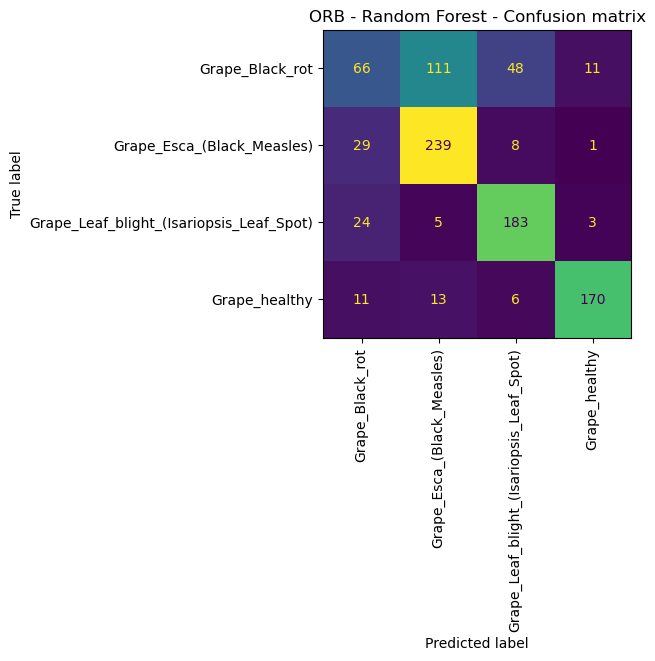

In [5]:
#
# ORB Random Forest
#
orb_rf_pipe = load_rf("models/orb_random_forest.pkl", orb_train_x, train_y)
analysis_rf("ORB", orb_rf_pipe, orb_test_x, test_y)

In [6]:
sift_train_x = sift_pv_vw.train_vw_freqs[...]
sift_test_x = sift_pv_vw.test_vw_freqs[...]

assert sift_train_x.shape[0] == train_y.shape[0]
assert sift_test_x.shape[0] == test_y.shape[0]

print("SIFT PlantVillage train Visual Words", sift_train_x.shape)
print("SIFT PlantVillage test Visual Words", sift_test_x.shape)

SIFT PlantVillage train Visual Words (3711, 500)
SIFT PlantVillage test Visual Words (928, 500)


Search time: 152.85 s
Best params {'forest_gump__n_estimators': 167}
Train score: 0.83

SIFT Random Forest n_estimators: 167
SIFT Random Forest test score: 0.8308
Effectifs test set:
Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


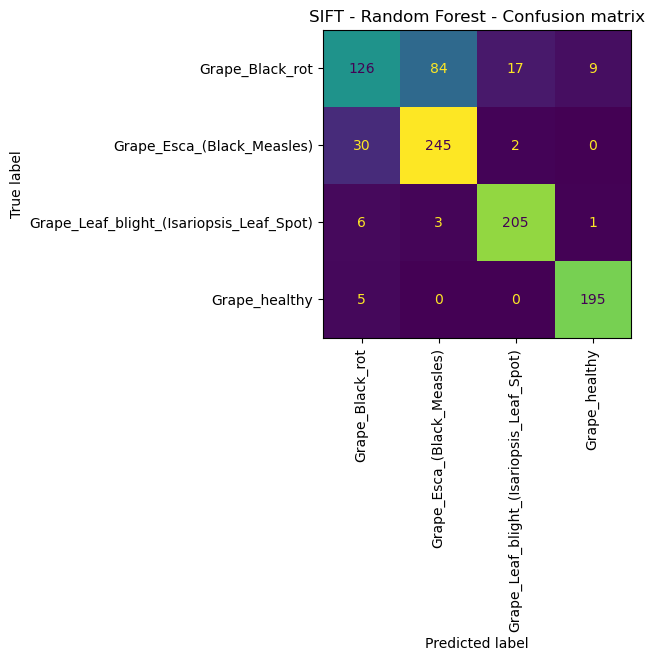

In [7]:
#
# SIFT Random Forest
#
sift_rf_pipe = load_rf("models/sift_random_forest.pkl", sift_train_x, train_y)
analysis_rf("SIFT", sift_rf_pipe, sift_test_x, test_y)